In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from keras.callbacks import ModelCheckpoint
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras import regularizers

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)

Using TensorFlow backend.


In [3]:
DATA_PATH = '/mnt/sdc1/inon/norrecampus/data/by_place_5min'
EXAMPLE_PLACE_ID = 'ChIJWZqpIVdSUkYRtXx0lXuClD0'


MINI_BATCH_SIZE = 512
NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2
NUM_LAGS = 12
LSTM_STATE_SIZE = NUM_LAGS * 5
NUM_OUTS_MEAN_SPEED_REGRESSION = 1
SPLIT_DATE = '2015-06-01'

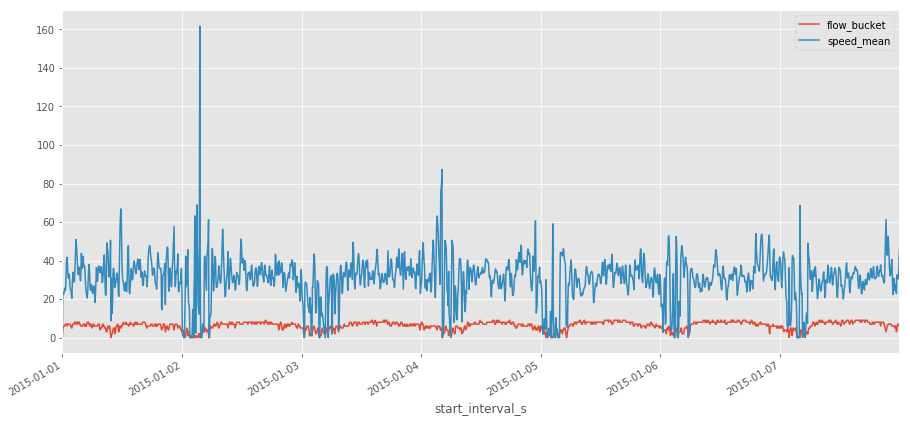

In [4]:
def get_df(place_id):
    return pd.read_csv(
        os.path.join(DATA_PATH, place_id + '.csv'),
        parse_dates=['start_interval_s', 'end_interval_s']
    )[lambda df: df.start_interval_s >= '2015-01-01']\
        .set_index('start_interval_s')\
        .drop('end_interval_s', axis=1)

example_df = get_df(EXAMPLE_PLACE_ID)
example_df[lambda df: df.index < '2015-01-08'].plot(figsize=(15, 7))

In [5]:
def get_train_and_test_inputs(place_id, num_lags, split_date, column):
    def windows(df):
        itr = (columns[1:] for columns in df[column].iteritems())
        window = list(next(itr) for _ in range(num_lags))
        while True:
            y = next(itr)
            yield np.array(window).flatten(), y
            window = (window + [y])[1:]
    
    def to_input_shape(df):
        return np.hsplit(np.array(list(windows(df))), 2)
    
    df_place_id = get_df(place_id)
    train_x, train_y = to_input_shape(df_place_id[lambda df: df.index < split_date]) 
    test_x, test_y = to_input_shape(df_place_id[lambda df: df.index >= split_date])
    return {
        'train_x': np.expand_dims(np.array([train_x[i][0] for i in range(len(train_x))]), 2),
        'train_y': np.column_stack(train_y.flatten()).transpose(),
        'test_x': np.expand_dims(np.array([test_x[i][0] for i in range(len(test_x))]), 2),
        'test_y': np.column_stack(test_y.flatten()).transpose(),
    }

train_and_test_sets = get_train_and_test_inputs(EXAMPLE_PLACE_ID, NUM_LAGS, SPLIT_DATE, 'speed_mean')
print(sorted([(k, v.shape) for k, v in train_and_test_sets.items()]))

[('test_x', (8279, 12, 1)), ('test_y', (8279, 1)), ('train_x', (42982, 12, 1)), ('train_y', (42982, 1))]


In [9]:
def build_model(loss, lags_back, lstm_state_size, num_outs):
    model = Sequential()
    model.add(LSTM(lstm_state_size, input_shape=(lags_back, 1), return_sequences=False))
    # model.add(Dropout(0.2))
    #model.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.00001)))
    model.add(Dense(units=num_outs, activation="relu"))  # TODO: try linear
    model.compile(loss=loss, optimizer="rmsprop")  # TODO: try adam optimizer too, although rmsprop is the default go-to for RNN
    SVG(model_to_dot(model).create(prog='dot', format='svg'))
    return model

In [10]:
def create_and_train_model(loss, lags_back, lstm_state_size, num_outs):
    model = build_model(loss, lags_back, lstm_state_size, num_outs)
    checkpoint_basename = 'simple_lstm.best.hdf5'
    model.fit(
        train_and_test_sets['train_x'],
        train_and_test_sets['train_y'],
        batch_size=MINI_BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_split=VALIDATION_SPLIT,
        # checkpoint best model
        callbacks=[ModelCheckpoint(checkpoint_basename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')],
        verbose=2)
    model.load_weights(checkpoint_basename)
    return model

model = create_and_train_model(
    loss='mse', lags_back=NUM_LAGS, lstm_state_size=LSTM_STATE_SIZE, num_outs=NUM_OUTS_MEAN_SPEED_REGRESSION)

Train on 34385 samples, validate on 8597 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 484.52124, saving model to simple_lstm.best.hdf5
4s - loss: 691.6482 - val_loss: 484.5212
Epoch 2/100
Epoch 00001: val_loss improved from 484.52124 to 356.50214, saving model to simple_lstm.best.hdf5
3s - loss: 425.1155 - val_loss: 356.5021
Epoch 3/100
Epoch 00002: val_loss improved from 356.50214 to 253.41490, saving model to simple_lstm.best.hdf5
3s - loss: 312.4574 - val_loss: 253.4149
Epoch 4/100
Epoch 00003: val_loss improved from 253.41490 to 174.14409, saving model to simple_lstm.best.hdf5
3s - loss: 223.0184 - val_loss: 174.1441
Epoch 5/100
Epoch 00004: val_loss improved from 174.14409 to 117.53396, saving model to simple_lstm.best.hdf5
3s - loss: 156.3604 - val_loss: 117.5340
Epoch 6/100
Epoch 00005: val_loss improved from 117.53396 to 79.19293, saving model to simple_lstm.best.hdf5
3s - loss: 110.1298 - val_loss: 79.1929
Epoch 7/100
Epoch 00006: val_loss improved from 79.19

Epoch 00069: val_loss improved from 33.56751 to 33.56510, saving model to simple_lstm.best.hdf5
3s - loss: 45.9218 - val_loss: 33.5651
Epoch 71/100
Epoch 00070: val_loss did not improve
3s - loss: 45.9753 - val_loss: 33.6509
Epoch 72/100
Epoch 00071: val_loss did not improve
3s - loss: 45.8974 - val_loss: 33.9927
Epoch 73/100
Epoch 00072: val_loss did not improve
3s - loss: 45.8158 - val_loss: 33.8846
Epoch 74/100
Epoch 00073: val_loss did not improve
3s - loss: 45.7968 - val_loss: 34.0579
Epoch 75/100
Epoch 00074: val_loss did not improve
3s - loss: 45.7585 - val_loss: 33.7982
Epoch 76/100
Epoch 00075: val_loss did not improve
3s - loss: 45.7476 - val_loss: 34.2863
Epoch 77/100
Epoch 00076: val_loss did not improve
3s - loss: 45.7022 - val_loss: 34.0123
Epoch 78/100
Epoch 00077: val_loss did not improve
4s - loss: 45.6709 - val_loss: 33.6355
Epoch 79/100
Epoch 00078: val_loss did not improve
3s - loss: 45.5800 - val_loss: 34.2519
Epoch 80/100
Epoch 00079: val_loss did not improve
3s -

In [23]:
def compute_error(trues, predicted):
    trues_and_a_bit = trues + 1E-6
    abs_errors = np.abs(predicted - trues_and_a_bit)
    abs_errors_normalized = abs_errors / trues_and_a_bit
    return {
        'corr': np.corrcoef(predicted, trues_and_a_bit)[0, 1],
        'mae': np.mean(abs_errors),
        'mape': np.mean(abs_errors_normalized),
        'mse': np.mean(abs_errors ** 2),
        'msne': np.mean(abs_errors_normalized ** 2),
        'rae': np.sum(abs_errors) / np.sum(np.abs(trues_and_a_bit - np.mean(trues_and_a_bit))),
        'rmse': np.sqrt(np.mean(abs_errors ** 2)),
        'rmsne': np.sqrt(np.mean(abs_errors_normalized ** 2)),
        'r2': max(0, 1 - np.sum((trues_and_a_bit - predicted) ** 2) / np.sum((trues - np.mean(trues_and_a_bit)) ** 2))
    }

In [24]:
predictions = model.predict(train_and_test_sets['test_x'])
compute_error(train_and_test_sets['test_y'], predictions)

/home/inonpe/jupyter/deep_learning_dtu/env/lib/python3.5/site-packages/numpy/lib/function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/inonpe/jupyter/deep_learning_dtu/env/lib/python3.5/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/inonpe/jupyter/deep_learning_dtu/env/lib/python3.5/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


{'corr': nan,
 'mae': 2.5974025191969532,
 'mape': 168238.7614058792,
 'mse': 43.119703803171156,
 'msne': 4097653247521.792,
 'r2': 0.54131542597655602,
 'rae': 0.43290172260844983,
 'rmse': 6.5665595103654661,
 'rmsne': 2024266.1009664198}

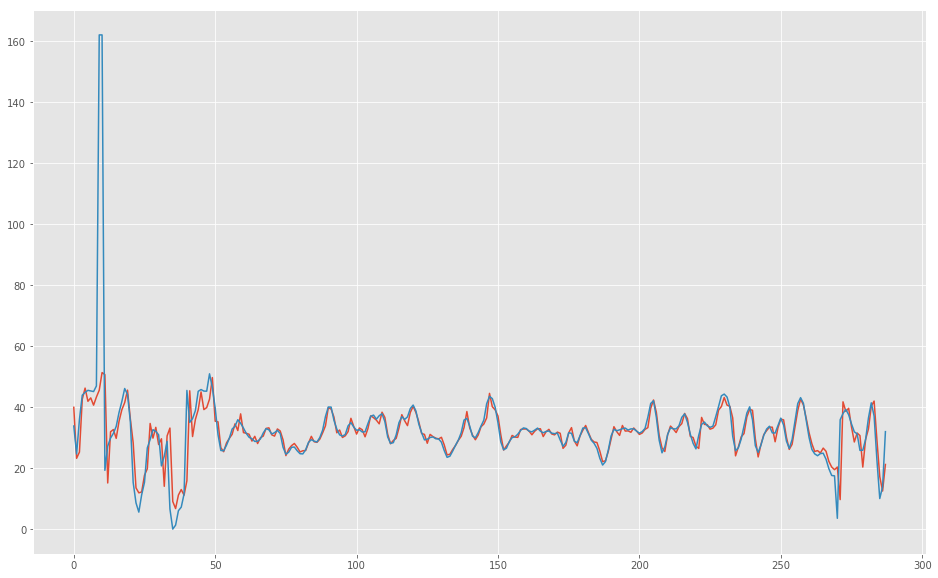

In [39]:
one_day = 288
plt.plot(range(one_day), predictions.flatten()[:one_day], range(one_day), train_and_test_sets['test_y'][:one_day])

In [41]:
df = get_df(EXAMPLE_PLACE_ID)
df.head()

,place_id,flow_bucket,speed_mean
start_interval_s,,,
2015-01-01 00:00:00,ChIJWZqpIVdSUkYRtXx0lXuClD0,0,0.000000
2015-01-01 00:05:00,ChIJWZqpIVdSUkYRtXx0lXuClD0,4,23.356085
2015-01-01 00:10:00,ChIJWZqpIVdSUkYRtXx0lXuClD0,5,22.693332
2015-01-01 00:15:00,ChIJWZqpIVdSUkYRtXx0lXuClD0,6,22.647396
2015-01-01 00:20:00,ChIJWZqpIVdSUkYRtXx0lXuClD0,6,22.830445


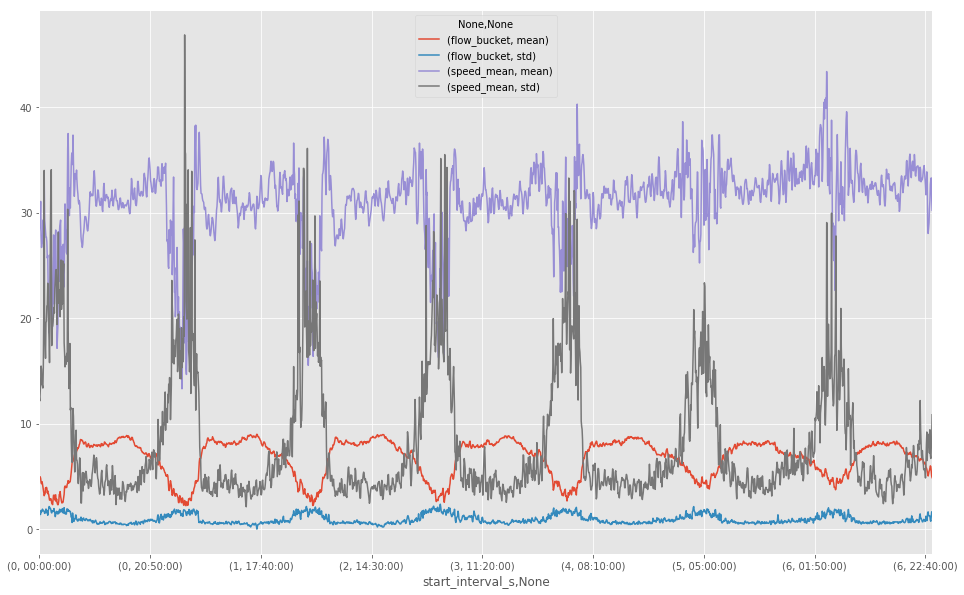

In [60]:
df.groupby([df.index.dayofweek, df.index.time]).agg(['mean', 'std']).plot()